[Tabular_Value_approach.ipynb](data_processing/neural_networks/RL_Reinforced_Learning/M_Lapan_book/Tabular_Value_approach.ipynb)

MDP can be deterministic or stochastic. 
*   `Deterministic MDP`:

    In this case reward $R(s^\prime, a)$ for reaching state $s^\prime$ via action $a$ is predefined and guaranteed.
    $$R(s^\prime, a) = const$$
    Actions $a$ taken from state $s$ guides an agent to target state $s^\prime$ with 100% certainty.

    $$P(s_i,a,s_j) = \begin{cases} 1, \text{ Transition defined} \\ 0, \text{ Transition undefined} \end{cases}$$



*   `Stochastic MDP`:

    In this case rewards for reaching state can be sampled from a distribution and, in general, can be a funciton of initial and target states $s^\prime$ and action that was taken
    $$ P_R = P(s_i, a, s_j, r = R)$$
    $$ \mathbb{E}[P_r(s_i,a,s_j, r)] = \sum_r r \cdot P(s_i, a, s_j, r = r)$$
    $$\sum_{r} P(s_i,a,s_j,r) = 1$$
    and taking an action might result in visiting one of multiple states.
    $$ 0 \leq  P(s_i,a,s_j) \leq 1$$
    $$\sum_{s_j} P(s_i,a,s_j) = 1$$

***
In following example we will examine case where 
*   agent has only 2 actions: move  left or right.

*   In some states applying action might propel agent further than usual- this is stochasticity of action-target-state.

*   Depending on how big was the 'jump' agent gets a reward proportional to displacement

*   Chances of random action are pre-baked into environment (like icy patch in "Frozen Lake")


In [204]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx import grid_graph
from misc_tools.print_latex import print_tex

1

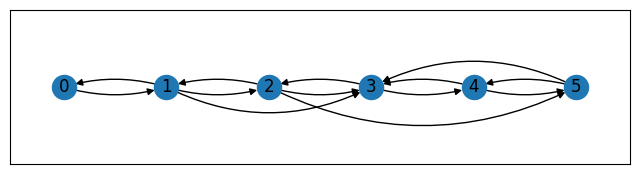

In [227]:
determenistic = False
np.random.seed(1)
num_nodes = 6
nodes_all = np.arange(num_nodes)
edges_1_step    = [(a,b) for a,b in zip(nodes_all[:-1],nodes_all[1:])]
edges_1_step_r  = [(b,a) for a,b in edges_1_step]
edges_2_step    = edges_3_step = []

if not determenistic:
    edges_2_step = [(1,3), (5,3)]
    edges_3_step = [(2,5)]


G = nx.DiGraph(edges_1_step + edges_1_step_r)
G.add_edges_from(edges_2_step + edges_3_step)

pos = {i:np.array([i,0]) for i in nodes_all}
fig, ax = plt.subplots(1,1, figsize = (8,2))
nx.draw_networkx_nodes( G, pos,ax = ax)
nx.draw_networkx_labels(G, pos,ax = ax)
nx.draw_networkx_edges( G, pos,ax = ax, connectionstyle="arc3,rad=0.15", edgelist=edges_1_step + edges_1_step_r)
nx.draw_networkx_edges( G, pos,ax = ax, connectionstyle="arc3,rad=0.25", edgelist=edges_2_step + edges_3_step)

#nx.draw_networkx_edge_labels(   G, pos, edge_labels= edge_labels);
1

In [206]:
a_right = 0
a_left = 1
actions = np.array([a_right,a_left])
actions_vis = np.array([[r'\rightarrow',r'\leftarrow']]).T

In [207]:
# rewards = leap length, leap length +/- 1 for all leap lengths > 1
rewards = np.arange(3 + 2)

if not determenistic:
    dists_distr = np.array([[0.8, 0.2, 0  , 0  , 0  ],
                            [0.2, 0.6, 0.2, 0  , 0  ],
                            [0  , 0.2, 0.6, 0.2, 0  ],
                            [0  , 0  , 0.2, 0.6, 0.2],
                            [0  , 0  , 0  , 0.2, 0.8]])
else:
    dists_distr = np.eye(len(rewards))

rewards_distr = {i:v for i,v in zip(rewards, dists_distr)}
expected_rewards = {i:np.average(rewards, weights=v) for i,v in zip(rewards, dists_distr)}
rewards_distr, expected_rewards

({0: array([0.8, 0.2, 0. , 0. , 0. ]),
  1: array([0.2, 0.6, 0.2, 0. , 0. ]),
  2: array([0. , 0.2, 0.6, 0.2, 0. ]),
  3: array([0. , 0. , 0.2, 0.6, 0.2]),
  4: array([0. , 0. , 0. , 0.2, 0.8])},
 {0: 0.2, 1: 1.0, 2: 2.0, 3: 3.0, 4: 3.8000000000000003})

In [208]:
adj = nx.adjacency_matrix(G).todense()
print_tex(adj)

<IPython.core.display.Math object>

Instead of $P(s,a,s',r)$ we will track $R(s,a,s',r)$, which gathers statistics from "experimental trials"

<i>$R(s,a,s^\prime,r)$  means $X$ times reward $r$ was given at state $s^\prime$ after transitioning via action $a$ from state $s$.</i>

Probabilities $P(s,a,s',r)$ are achieved by normalizing $R(s,a,s',r)$.

I don't sample stochastically, just say that number of events is proportional to distribution. Distribution is based on leap length. Number of longer leaps is reduced by factor of leap length.

So. Shorter leaps = less expected reward (due to distribution) but more detections. Longer leaps = more reward but less detections (due to suppression of events).


In [209]:
Psasr = np.zeros((num_nodes,len(actions),num_nodes,len(rewards)))
for i in G.nodes():
    neighbors = list(G.neighbors(i))
    for j in neighbors:
        action = a_right if j > i else a_left
        dist = np.abs(j-i)
        #rew, cnts = np.unique(np.random.choice(rewards, p=rewards_distr[1], size = (100,)), return_counts=True)
        Psasr[i,action,j] = rewards_distr[dist]*100//(dist**2)
        
print(f'{Psasr[i,action,j] = }')

Psasr[i,action,j] = array([ 0.,  5., 15.,  5.,  0.])


$\Rightarrow$ count up reward events (dim = -1) for each $(s,a,s')$

For example from node 1 we can move right (0) and left (1):
*   Right
    *   $(1,0,2)$: Single step leap (100 events)   to node 2 
    *   $(1,0,3)$: Two step leap (25 events)       to node 3 
*   Left
    *   $(1,1,0)$: Single step leap (100 events)   to node 0 

In [210]:
num_rewards = np.sum(Psasr, axis = (-1))
print_tex(num_rewards[1],actions_vis)

<IPython.core.display.Math object>

Expected reward for reaching state $s^\prime$ from state $s$ via action $a$
$$\bar R(s,a, s^\prime) = \mathbb{E}_r[R(s,a,s^\prime,r)] = \sum_r r \cdot P(s,a,s^\prime,r) = \frac{\sum_r r \cdot R(s,a,s^\prime,r)}{\sum_r R(s,a,s^\prime,r)}

In [211]:
sum_rewards = (Psasr @ rewards)
Rsas = np.divide(sum_rewards, num_rewards, where= (num_rewards != 0)) 
print_tex(Rsas[1])

<IPython.core.display.Math object>

Expected reward for taking action $a$ in state $s$:
$$Q(s,a) = \mathbb{E}_{s^\prime}[\bar R(s,a, s^\prime)] = 
\sum_{s^\prime} \bar R(s,a, s^\prime) \cdot P(s,a,s^\prime) =
\frac{\sum_{s^\prime }\left[\sum_r r \cdot R(s,a,s^\prime,r)\right]}{\sum_{s^\prime }\left[\sum_r R(s,a,s^\prime,r)\right]}$$

$\underset{r,s^\prime }{\sum} R(s,a,s^\prime,r)$ is number of all events detected from state $s$ while doing action $a$

In [212]:
num_states = np.sum(Psasr, axis = (-1,-2))
print(num_states.shape)
sum_rewards_states = np.sum(sum_rewards, axis = (-1))
Qsa = np.divide(sum_rewards_states, num_states, where= (num_states != 0)) 
print_tex(Qsa, np.array([[f's_{i}' for i in nodes_all]]).T)
print_tex(actions_vis.T)

(6, 2)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

State-value:
$$V(s) = \mathbb{E}_a[Q(s,a)] = \sum_a P(a,s) \cdot Q(s,a)=
\frac{\sum_a \left( \sum_{s^\prime }\left[\sum_r r \cdot R(s,a,s^\prime,r)\right] \right)}{\sum_a \left( \sum_{s^\prime }\left[\sum_r R(s,a,s^\prime,r)\right] \right)}$$

or
$$V(s) = \sum_a P(a,s)\cdot \sum_{s^\prime }\sum_r r \cdot P(s,a,s^\prime,r)
= \sum_a P(a,s)\cdot  \frac{\sum_{s^\prime }\left[\sum_r r \cdot R(s,a,s^\prime,r)\right]}{ \sum_{s^\prime }\left[\sum_r R(s,a,s^\prime,r)\right]}$$


In [215]:
sum_rew_states = np.sum(Psasr, axis = (-1,-2,-3))
sum_rewards_states_act = np.sum(sum_rewards, axis = (-1,-2))
Vs = np.divide(sum_rewards_states_act, sum_rew_states, where= (sum_rew_states != 0)) 
#
print_tex(Vs)

<IPython.core.display.Math object>

For stochastic case, expected value of each state is higher for nodes with more actions

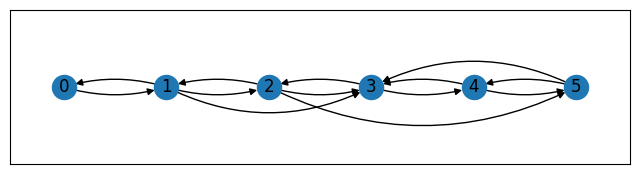

In [228]:
display(fig)